# Identifying Traffic Congestion and Time Using Uber Ride Data and ANOVA

Rideshare companies like Uber and Lyft have recently begun publishing their collection of traffic data that may be valuable in the research of transportation and urban planning. Measurements like pick-up times, drop-off times, and routing might be the best available proxy for traffic congestion. This data can then be used to see which routes may be under- or over-performing with regard to expectation, which can then be used to help inform policy regarding city planning, traffic, infrastructure maintenence, public safety, population growth, and more.

But given the large number of external influences on traffic congestion, distance and time alone are not enough to be able to identify under-performing city routes. Traffic is naturally dictated not just by the routes themselves, but also according to time of day, day of week, time of year, weather, local events, and more. These external factors need to be identified so that city officials can then determine whether or not periods of congestion are due to these natural fluctuations in predictable time, weather, and event-related phenomena, or whether these anomalies need a solution that's related to the city infrastructure itself. 

Here is a small example model that explores both internal and external events. A two-way analysis of variance looks at 3 different possible trip routes in San Francisco and groups them by time of day. Daily mean travel times are then analyzed to see which routes have the fastest travel times. Routes are then analyzed for interaction effects with time of day to see if any routes experience more or less congestion than expected at certain times of day. 

In [1]:
usf  <- read.csv("USF_Travel_Times_Daily.csv")
ucb  <- read.csv("UCB_Travel_Times_Daily.csv")
stan <- read.csv("STAN_Travel_Times_Daily.csv")

usf$Trip.Type  <- "usf"
ucb$Trip.Type  <- "ucb"
stan$Trip.Type <- "stan"
trips <- rbind(usf,ucb,stan)

Data above was obtained from the Uber Movement project, an open dataset of aggregated rideshare trip data. Out of the cities available, we selected San Francisco. On the data's website, users can select an origin location and a destination location based on US census tract zones. Daily, aggregated travel time data can then be retrieved for all trips to and from the two specified locations. Data includes mean daily travel time, along with their upper and lower bounds, and then mean travel times by different times of day. 

Link to data:
https://movement.uber.com/?lang=en-US

In [2]:
head(trips)

Date,Origin.Movement.ID,Origin.Display.Name,Destination.Movement.ID,Destination.Display.Name,Daily.Mean.Travel.Time..Seconds.,Daily.Range...Lower.Bound.Travel.Time..Seconds.,Daily.Range...Upper.Bound.Travel.Time..Seconds.,AM.Mean.Travel.Time..Seconds.,AM.Range...Lower.Bound.Travel.Time..Seconds.,⋯,Midday.Mean.Travel.Time..Seconds.,Midday.Range...Lower.Bound.Travel.Time..Seconds.,Midday.Range...Upper.Bound.Travel.Time..Seconds.,Evening.Mean.Travel.Time..Seconds.,Evening.Range...Lower.Bound.Travel.Time..Seconds.,Evening.Range...Upper.Bound.Travel.Time..Seconds.,Early.Morning.Mean.Travel.Time..Seconds.,Early.Morning.Range...Lower.Bound.Travel.Time..Seconds.,Early.Morning.Range...Upper.Bound.Travel.Time..Seconds.,Trip.Type
01/01/2018,234,"San Francisco International Airport, San Francisco, CA",907,"University of San Francisco, 2130 Fulton St, San Francisco, CA",1645,1329,2037,1410,1080,⋯,1657,1382,1987,1668,1360,2045,1311,1119,1534,usf
01/02/2018,234,"San Francisco International Airport, San Francisco, CA",907,"University of San Francisco, 2130 Fulton St, San Francisco, CA",1721,1339,2212,NA,NA,⋯,2024,1680,2439,1506,1240,1829,1338,1064,1683,usf
01/03/2018,234,"San Francisco International Airport, San Francisco, CA",907,"University of San Francisco, 2130 Fulton St, San Francisco, CA",1778,1413,2237,NA,NA,⋯,2010,1755,2302,1544,1293,1844,1260,1084,1464,usf
01/04/2018,234,"San Francisco International Airport, San Francisco, CA",907,"University of San Francisco, 2130 Fulton St, San Francisco, CA",1984,1469,2678,2056,1764,⋯,2043,1722,2424,1440,1216,1706,1411,1207,1649,usf
01/05/2018,234,"San Francisco International Airport, San Francisco, CA",907,"University of San Francisco, 2130 Fulton St, San Francisco, CA",1971,1551,2503,2110,1750,⋯,2001,1751,2288,1677,1410,1995,NA,NA,NA,usf
01/06/2018,234,"San Francisco International Airport, San Francisco, CA",907,"University of San Francisco, 2130 Fulton St, San Francisco, CA",1787,1407,2271,1707,1415,⋯,1900,1552,2326,1505,1261,1796,1371,1147,1638,usf


In [3]:
keep <- c("Date", "Early.Morning.Mean.Travel.Time..Seconds.", "AM.Mean.Travel.Time..Seconds.", 
          "Midday.Mean.Travel.Time..Seconds.", "PM.Mean.Travel.Time..Seconds.", 
          "Evening.Mean.Travel.Time..Seconds.", "Trip.Type")
trips <- trips[keep]

Currently the data is in wide-form table, where Early.Morning.Time is a column of seconds, Midday.Time is a column of seconds, Evening.Time is a column of seconds, and so on. Instead, we want to convert this into a long-form table format, where all six times are represented as a single column called "Time" which is a categorical variable with six factors. We can do this with the **melt** function.

In [4]:
library(reshape)

trips <- melt(trips, id=c("Date","Trip.Type"))
names(trips) <- c("Date", "Trip.Route", "Time", "Mean.Trip.Time")
trips$Time <- as.factor(trips$Time)
levels(trips$Time) <- c("Early.Morning", "AM.Peak", "Midday", "PM.Peak", "Evening")
head(trips)

Date,Trip.Route,Time,Mean.Trip.Time
01/01/2018,usf,Early.Morning,1311
01/02/2018,usf,Early.Morning,1338
01/03/2018,usf,Early.Morning,1260
01/04/2018,usf,Early.Morning,1411
01/05/2018,usf,Early.Morning,NA
01/06/2018,usf,Early.Morning,1371


Now we must convert our trip distance measurement into trip time. 

In [5]:
usf_distance  <- 26.1 # miles as computed via Google Maps
ucb_distance  <- 25.1 # miles as computed via Google Maps
stan_distance <- 26.9 # miles as computed via Google Maps

# creates a 'speed' category by dividing distance (miles) by seconds
trips$Speed = 0
trips[trips$Trip.Route == "usf",]$Speed  <- usf_distance / trips[trips$Trip.Route == "usf",]$Mean.Trip.Time
trips[trips$Trip.Route == "ucb",]$Speed  <- ucb_distance / trips[trips$Trip.Route == "ucb",]$Mean.Trip.Time
trips[trips$Trip.Route == "stan",]$Speed <- stan_distance / trips[trips$Trip.Route == "stan",]$Mean.Trip.Time

# converts to 'miles per minute'
trips$Speed <- trips$Speed * 60

head(trips)

Date,Trip.Route,Time,Mean.Trip.Time,Speed
01/01/2018,usf,Early.Morning,1311,1.194508
01/02/2018,usf,Early.Morning,1338,1.170404
01/03/2018,usf,Early.Morning,1260,1.242857
01/04/2018,usf,Early.Morning,1411,1.109851
01/05/2018,usf,Early.Morning,NA,NA
01/06/2018,usf,Early.Morning,1371,1.142232


Days with insufficient data during a specified time may have an NA. These need to be imputed or omitted. 

In [6]:
tripsN <- na.omit(trips)

Now we can start our anlysis. For a preliminary analysis, we can just simply look at the mean speeds and see how they differ. First looking at differences in our first variable which is trip **route**:

[1] 0.8599202

[1] 0.5420985

[1] 0.7858521

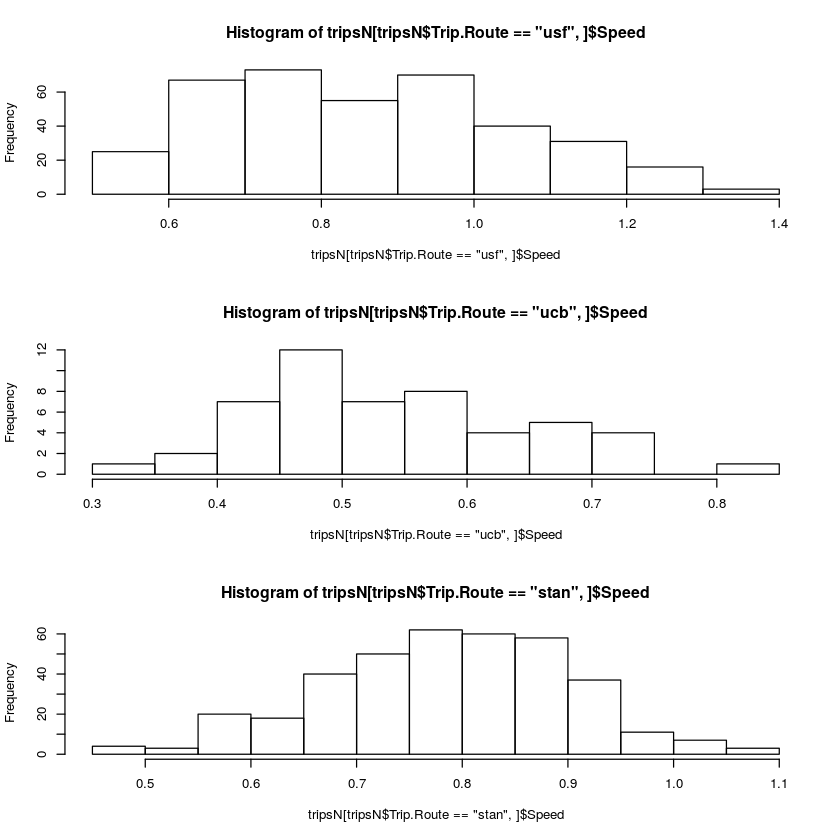

In [7]:
mean(tripsN[tripsN$Trip.Route == "usf",]$Speed)
mean(tripsN[tripsN$Trip.Route == "ucb",]$Speed)
mean(tripsN[tripsN$Trip.Route == "stan",]$Speed)

par(mfrow=c(3,1))
hist(tripsN[tripsN$Trip.Route == "usf",]$Speed)
hist(tripsN[tripsN$Trip.Route == "ucb",]$Speed)
hist(tripsN[tripsN$Trip.Route == "stan",]$Speed)

Now looking at trip **time of day**:

[1] 1.052835

[1] 0.7231771

[1] 0.7304642

[1] 0.702793

[1] 0.8887894

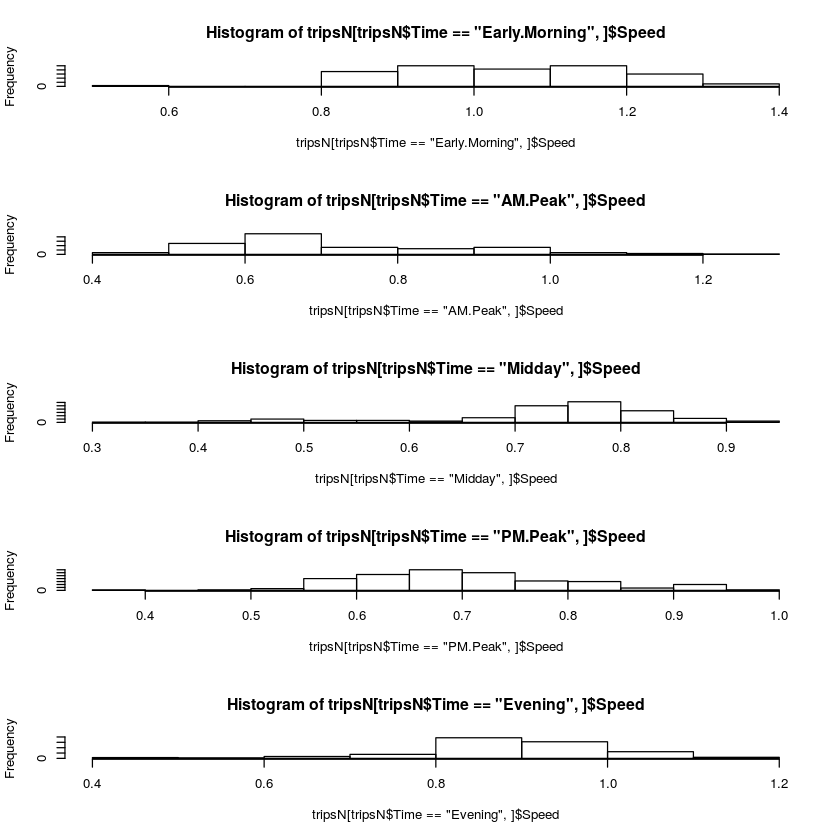

In [8]:
par(mfrow=c(5,1))
hist(tripsN[tripsN$Time == "Early.Morning",]$Speed)
hist(tripsN[tripsN$Time == "AM.Peak",]$Speed)
hist(tripsN[tripsN$Time == "Midday",]$Speed)
hist(tripsN[tripsN$Time == "PM.Peak",]$Speed)
hist(tripsN[tripsN$Time == "Evening",]$Speed)

mean(tripsN[tripsN$Time == "Early.Morning",]$Speed)
mean(tripsN[tripsN$Time == "AM.Peak",]$Speed)
mean(tripsN[tripsN$Time == "Midday",]$Speed)
mean(tripsN[tripsN$Time == "PM.Peak",]$Speed)
mean(tripsN[tripsN$Time == "Evening",]$Speed)

Now we want to be able to compute aggregate tables for each combination of our two variables.

In [9]:
agg.trips <- aggregate(tripsN, by=list(na.omit(trips)$Trip.Route, na.omit(trips)$Time), FUN=mean, na.rm=TRUE)
keep <- c("Group.1", "Group.2","Mean.Trip.Time","Speed")
agg.trips <- agg.trips[keep]
names(agg.trips) <- c("Route.To", "Time.of.Day", "Mean.Trip.Time", "Speed")
agg.trips

Route.To,Time.of.Day,Mean.Trip.Time,Speed
stan,Early.Morning,1725.224,0.9396749
ucb,Early.Morning,2330.500,0.6714137
usf,Early.Morning,1354.860,1.1634964
stan,AM.Peak,2443.178,0.6847027
ucb,AM.Peak,2145.000,0.7020979
usf,AM.Peak,2109.241,0.7755792
stan,Midday,2119.344,0.7645045
ucb,Midday,3115.467,0.4929430
usf,Midday,2033.278,0.7755976
stan,PM.Peak,2250.549,0.7238346


We can use interaction plots to check the existence of interaction effects between our two variables:

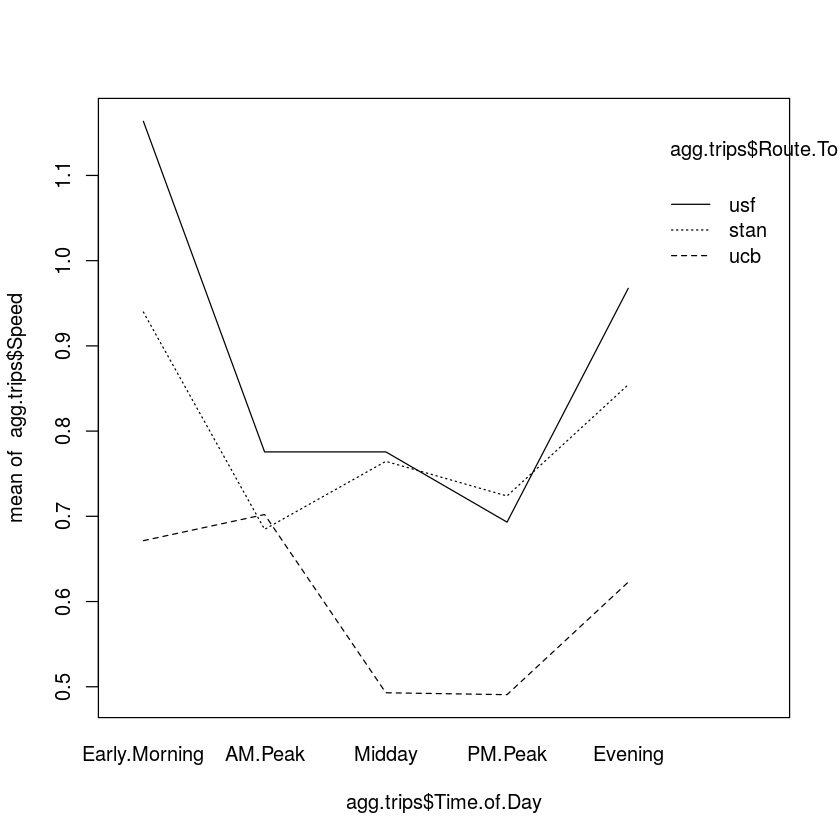

In [10]:
interaction.plot(agg.trips$Time.of.Day, agg.trips$Route.To, agg.trips$Speed)

The interaction plot above is able to identify that some routes are disproportionately congested at some times of day than others. For example, while we can see that the USF and Stanford trips experience notably more congestion in the AM Peak than in the Early Morning time periods, UCB actually experiences less congestion. On the other hand, the UCB road experiences a drastic increase in congestion fromin the Midday period, where the other two routes actually get a small increase in congestion during that same time frame. 

In [33]:
fit.additive <- aov(Speed~Trip.Route+Time, data=tripsN)
anova(fit.additive)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Trip.Route,2,4.807775,2.40388749,237.0669,1.625203e-81
Time,4,11.297778,2.82444445,278.5415,1.003851e-149
Residuals,797,8.081676,0.01014012,NA,NA


which yielded statistically significant differences in the groups means between different times of day (F = 4.887, p = 0.0272) and staistially significant differences in the group means between different routes (F = 9.979458, p =0.0067). For both factors, we have p<0.05, and we can reject our first two null hypotheses with statistical significance. We can conclude that there is likely a difference between route travel times and time-of-day travel times that cannot be accounted for by randomness alone.

Now allowing for interaction:

In [34]:
fit.interactive <- aov(Speed~Trip.Route*Time, data=tripsN)
anova(fit.interactive)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Trip.Route,2,4.807775,2.403887494,282.86736,2.400886e-93
Time,4,11.297778,2.824444451,332.35463,1.515944e-167
Trip.Route:Time,8,1.376529,0.172066156,20.24716,5.436553e-28
Residuals,789,6.705147,0.008498285,NA,NA


Finally, using Tukey intervals:

In [35]:
TukeyHSD(fit.additive)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Speed ~ Trip.Route + Time, data = tripsN)

$Trip.Route
                diff         lwr         upr p adj
ucb-stan -0.24375353 -0.27905402 -0.20845305     0
usf-stan  0.07406816  0.05683406  0.09130225     0
usf-ucb   0.31782169  0.28256034  0.35308305     0

$Time
                             diff         lwr          upr     p adj
AM.Peak-Early.Morning -0.32442358 -0.36039557 -0.288451604 0.0000000
Midday-Early.Morning  -0.28471492 -0.31731489 -0.252114945 0.0000000
PM.Peak-Early.Morning -0.35142038 -0.38557930 -0.317261452 0.0000000
Evening-Early.Morning -0.14490315 -0.17792621 -0.111880089 0.0000000
Midday-AM.Peak         0.03970867  0.00883637  0.070580962 0.0042060
PM.Peak-AM.Peak       -0.02699679 -0.05951098  0.005517398 0.1557309
Evening-AM.Peak        0.17952043  0.14820170  0.210839166 0.0000000
PM.Peak-Midday        -0.06670546 -0.09544476 -0.037966157 0.0000000
Evening-Midday    

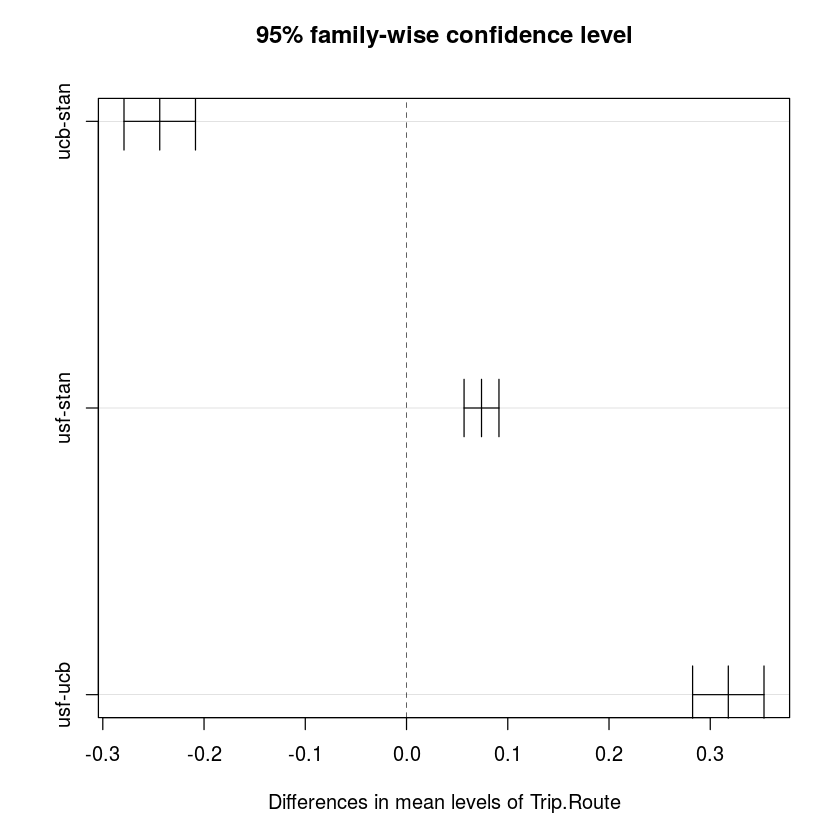

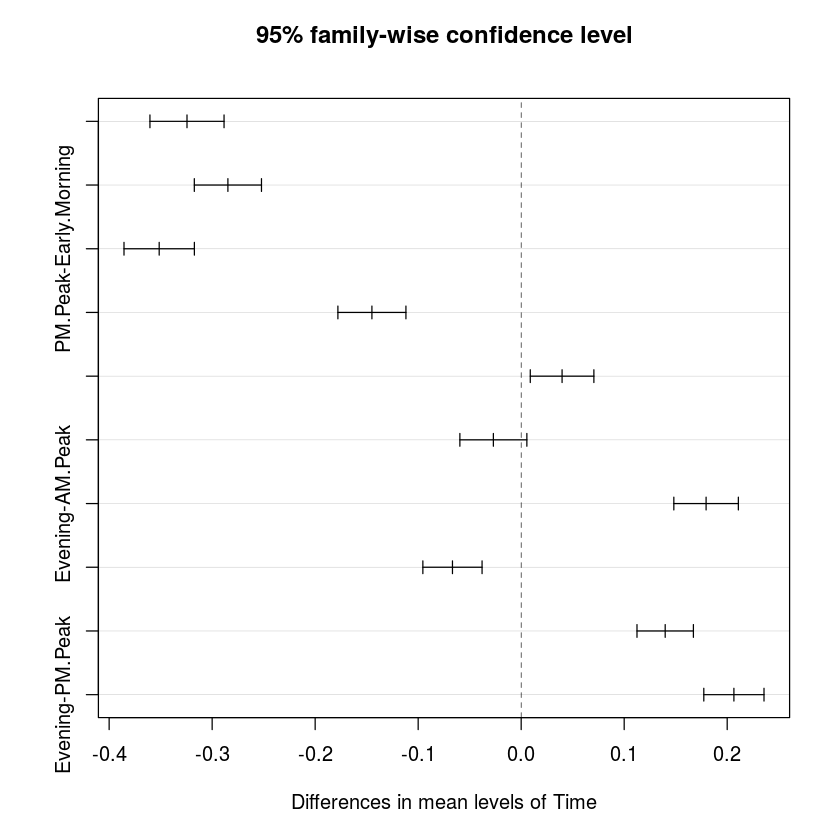

In [37]:
plot(TukeyHSD(fit.additive))